В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [12]:
from process_bank_churn5 import preprocess_data,preprocess_new_data
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

In [2]:
raw_df = pd.read_csv('train.csv',index_col=0)

In [62]:
X_train, train_targets, X_val, val_targets, input_cols, scaler, encoder = preprocess_data(raw_df)

In [63]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
id,,,,,,,,,,,,,
7180,0.599045,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.603819,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.653938,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.568019,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.658711,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [33]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [64]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [47]:
def roc(inputs,targets,model,name):
  roc_auc = roc_auc_score(targets, model.predict_proba(inputs)[:, 1])
  print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")

In [65]:
roc(X_train,train_targets,knn,'Train')
roc(X_val,val_targets,knn,'Validation')

Area under ROC score on Train dataset: 0.96%
Area under ROC score on Validation dataset: 0.85%


> низький bias оскільки добре навчилась на тренувальних даних, але при цьому набагато гірше спрацювала на валідаційних (оверфітінг)



2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [66]:
knn_grid = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn_grid, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [67]:
knn_best = knn_gs.best_estimator_
knn_gs.best_estimator_

KNeighborsClassifier(n_neighbors=np.int64(9))

In [68]:
roc(X_train,train_targets,knn_best,'Train')
roc(X_val,val_targets,knn_best,'Validation')

Area under ROC score on Train dataset: 0.94%
Area under ROC score on Validation dataset: 0.88%




> вона покращилась, якщо порівнювати результат вище. але з деревом рішенням - ні (якщо там де ще й заданий параметр)



3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [69]:
tree_grid = DecisionTreeClassifier(random_state=42)
params_tree = {'max_depth': np.arange(1, 20, 2),
               'max_leaf_nodes':np.arange(2, 20)}

In [70]:
%%time
tree_gs = GridSearchCV(tree_grid, params_tree, cv=3, scoring='roc_auc')
tree_gs.fit(X_train, train_targets)

CPU times: user 9.6 s, sys: 17.7 ms, total: 9.62 s
Wall time: 9.64 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])},
             scoring='roc_auc')

In [71]:
dt_best = tree_gs.best_estimator_
tree_gs.best_estimator_

DecisionTreeClassifier(max_depth=np.int64(5), max_leaf_nodes=np.int64(19),
                       random_state=42)

In [72]:
roc(X_train,train_targets,dt_best,'Train')
roc(X_val,val_targets,dt_best,'Validation')

Area under ROC score on Train dataset: 0.92%
Area under ROC score on Validation dataset: 0.92%


> ну чисто відсотково по AUROC то така сама, питання як вона з тестовими данними спрацює

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [73]:
dt_ran = DecisionTreeClassifier(random_state=42)
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [74]:
%%time
tree_rs = RandomizedSearchCV(dt_ran, params_dt, cv=3, scoring='roc_auc',random_state=42)
tree_rs.fit(X_train, train_targets)

CPU times: user 259 ms, sys: 995 µs, total: 260 ms
Wall time: 260 ms


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [75]:
dt_random_search_best = tree_rs.best_estimator_
tree_rs.best_estimator_

DecisionTreeClassifier(max_depth=np.int64(10), max_leaf_nodes=np.int64(16),
                       min_samples_leaf=4, min_samples_split=20,
                       random_state=42, splitter='random')

In [76]:
roc(X_train,train_targets,dt_best,'Train')
roc(X_val,val_targets,dt_best,'Validation')

Area under ROC score on Train dataset: 0.92%
Area under ROC score on Validation dataset: 0.92%


In [59]:
params_dt_best = {
    'criterion': dt_best.criterion,
    'splitter': dt_best.splitter,
    'max_depth': dt_best.max_depth,
    'max_leaf_nodes': dt_best.max_leaf_nodes,
    'min_samples_split': dt_best.min_samples_split,
    'min_samples_leaf': dt_best.min_samples_leaf,
    'max_features': dt_best.max_features
}

In [60]:
params_dt_random_search_best = {
    'criterion': dt_random_search_best.criterion,
    'splitter': dt_random_search_best.splitter,
    'max_depth': dt_random_search_best.max_depth,
    'max_leaf_nodes': dt_random_search_best.max_leaf_nodes,
    'min_samples_split': dt_random_search_best.min_samples_split,
    'min_samples_leaf': dt_random_search_best.min_samples_leaf,
    'max_features': dt_random_search_best.max_features
}

In [61]:
params_df = pd.DataFrame({
    'GridSearchCV': params_dt_best,
    'RandomSearchCV': params_dt_random_search_best
})
params_df

,GridSearchCV,RandomSearchCV
criterion,gini,gini
splitter,best,random
max_depth,5,10
max_leaf_nodes,19,16
min_samples_split,2,20
min_samples_leaf,1,4
max_features,None,None




> можливо десь щось не так роблю (хех) але тут вийшло то саме, яке зверху і яке вручну підібране. тому складно зрозуміти як впливають параметри, хоч по деяких з них прям велика різниця (2 і 20 наприклад)



5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [43]:
test_raw_df = pd.read_csv('test.csv',index_col=0)
sample_df = pd.read_csv('sample_submission.csv')

In [77]:
df_test = preprocess_new_data(test_raw_df,input_cols,scaler,encoder)

In [79]:
test_preds = dt_best.predict_proba(df_test)[:, 1]
sample_df.Exited = test_preds
sample_df.to_csv('submission_log_reg_gs.csv',index=False)

In [80]:
test_preds = dt_random_search_best.predict_proba(df_test)[:, 1]
sample_df.Exited = test_preds
sample_df.to_csv('submission_log_reg_rs.csv',index=False)

мій скор на таблиці 0.93

а це з dt_best та dt_random_search_best

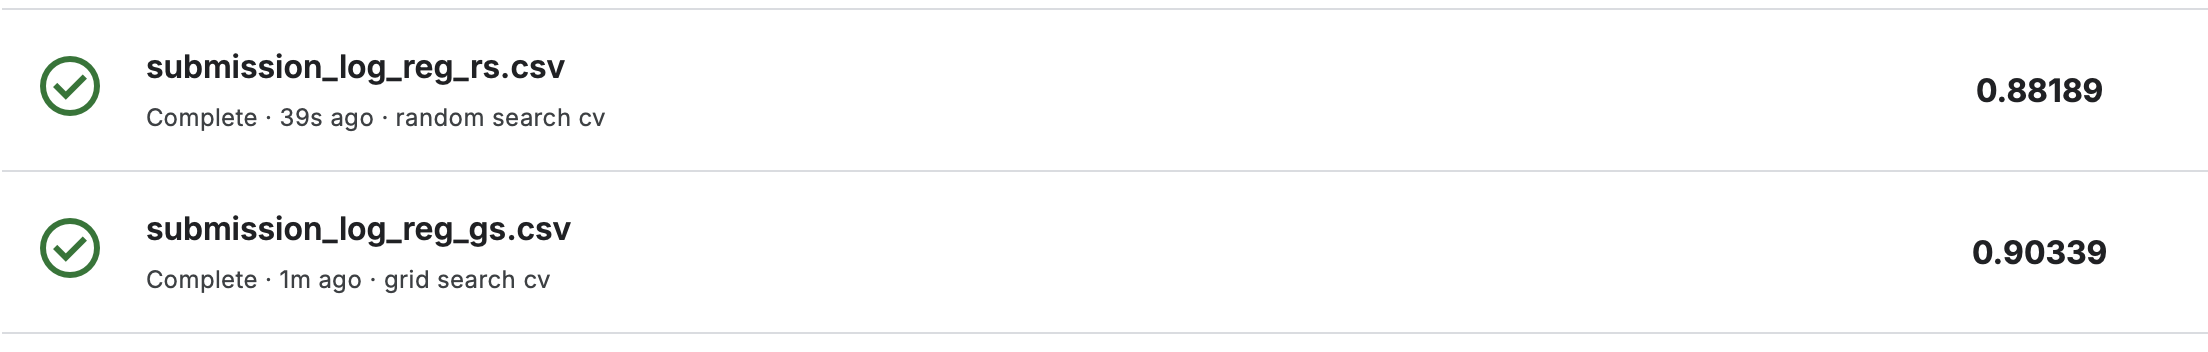